In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.preprocessing import power_transform
from copy import deepcopy as dc

import torch
import torch.nn as nn

## Constant Variables

In [2]:
TRAIN_PATH = "data/train.csv"
TEST_FILE_PATH = "data/test.csv"
LOOKBACK = 6

EPOCH = 10
BATCH_SIZE = 16
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
LOSS_FUNCTION = nn.MSELoss()

## Draw Utils

In [3]:
def draw_dist(df):
    fig = plt.figure(figsize=(20, 40))
    ax = []

    count = 1  # Counter for subplot position

    for i, column in enumerate(df):
        if df[column].dtype == 'float64':
            ax = fig.add_subplot(10, 4, count)
            sns.distplot(df[column], color='g', bins=100, ax=ax)
            count += 1  # Increment counter

    plt.tight_layout()
    plt.show()

In [4]:
def draw_box(df):
    # Create a boxplot figure
    fig = plt.figure(figsize=(20, 40))
    count = 1
    for i, column in enumerate(df.columns):
        if df[column].dtype == 'float64':
            ax = fig.add_subplot(10, 4, count)
            sns.boxplot(y=df[column], color='g', ax=ax)
            count += 1

    plt.tight_layout()
    plt.show()

## Data set up

In [104]:
train_data = pd.read_csv(TRAIN_PATH)
train_data

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [6]:
train_data.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


In [105]:
# it's been found that if there are Null in wap, other variables are also unavailable
train_df = dc(train_data)
train_df.dropna(subset=["wap"], inplace=True)

In [106]:
train_df["imbalance_size"] = train_df["imbalance_size"] * train_df["imbalance_buy_sell_flag"]
train_df["seconds_in_bucket"] = train_df["seconds_in_bucket"] + train_df["date_id"] * 540
train_df.drop(["imbalance_buy_sell_flag", "row_id"], axis=1, inplace=True)

train_df["book_imbalance"] = (train_df["bid_size"] - train_df["ask_size"]) / (train_df["bid_size"] + train_df["ask_size"])
train_df = train_df.query("target<20 & target>-20")

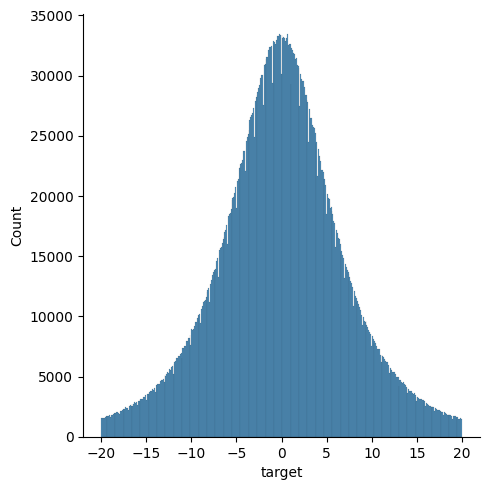

In [107]:
sns.displot(train_df["target"])

In [109]:
def prepare_dataframe_for_lstm(df, n_steps):
    """
    this function calculates %changes in book_imbalance as variables for the LSTM. 
    input: 
        df: pandas.DataFrame
        n_steps: int64, gap of days to calculate %changes of book_imbalance
    output: 
        output_df: pandas.DataFrame, at least contains columns of stock_id, seconds_in_bucket, target, book_imbalance 
                    followed by the %changes of book imbalance
                    the dataframe is sorted by stock_id 
    """
    df = dc(df)

    output_df = df.sort_values(by=["stock_id", "seconds_in_bucket"]).select_dtypes(include=["int64"])
    output_df["target"] = df["target"]
    output_df["book_imbalance"] = df["book_imbalance"]

    for i in range(1, n_steps+1):
        output_df[f'book_imbalance_change_{i}'] = (output_df["book_imbalance"]-output_df["book_imbalance"].shift(i)) / output_df["book_imbalance"].shift(i)

    output_df.dropna(inplace=True)
    output_df = output_df.drop(["time_id", "date_id"], axis=1,)
    output_df = output_df.loc[output_df["seconds_in_bucket"]>50]
    #remove outliers
    for i in range(1, n_steps+1):
        output_df = output_df.query(f'book_imbalance_change_{i}>-20')        #TODO: if the training result is not good, the outlier threshold might be changed
        output_df = output_df.query(f'book_imbalance_change_{i}<20')
    return output_df
    
df = prepare_dataframe_for_lstm(train_df, n_steps=LOOKBACK)
df

,stock_id,seconds_in_bucket,target,book_imbalance,book_imbalance_change_1,book_imbalance_change_2,book_imbalance_change_3,book_imbalance_change_4,book_imbalance_change_5,book_imbalance_change_6
1146,0,60,-0.200272,0.162739,-0.736955,-1.561766,0.698071,-1.366126,-1.641128,-0.784264
1337,0,70,2.410412,0.371575,1.283266,-0.399398,-2.282662,2.877147,-1.835964,-2.463866
1528,0,80,-0.389814,-0.735972,-2.980680,-5.522421,-2.189600,1.540543,-8.679390,0.655777
1719,0,90,-4.339814,-0.268035,-0.635808,-1.721347,-2.647028,-1.433242,-0.074755,-3.796770
1910,0,100,-2.049804,-0.625701,1.334401,-0.149831,-2.683914,-4.844823,-2.011362,1.159892
...,...,...,...,...,...,...,...,...,...,...
5236779,199,259680,4.299879,-0.099488,-0.572394,-7.563143,-2.665993,-1.457703,-1.550173,-1.231749
5236979,199,259690,-2.139807,-0.036526,-0.632858,-0.843008,-3.409605,-1.611656,-1.168042,-1.201992
5237579,199,259720,3.629923,0.073171,-0.772710,-1.132203,-3.003241,-1.735474,-1.314493,3.827020
5237779,199,259730,4.760027,0.142071,0.941636,-0.558685,-1.256690,-4.889565,-2.428022,-1.610632


<Axes: title={'center': 'Scaled Stock 10'}, xlabel='seconds_in_bucket'>

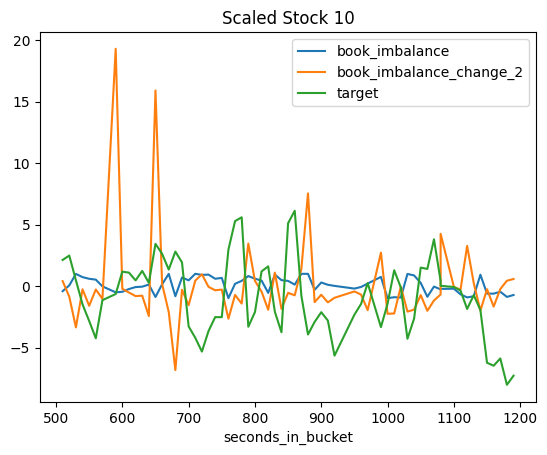

In [34]:
stock_id = 10
(
    df
    .query("stock_id=={} & seconds_in_bucket > 500 & seconds_in_bucket < 1200".format(stock_id))
    [['seconds_in_bucket',"book_imbalance", 'book_imbalance_change_2', 'target']]
    .replace(0, np.nan)
    .set_index('seconds_in_bucket')
    .plot(title='Scaled Stock {}'.format(stock_id))
)

In [34]:
def scale_stock(df, column_names=[], stock_id=None):
    """
    scale the dataframe with designated stock_id to data ranged between -1 and 1 using yeo-jouhnson and MinMaxScaler
    Yeo-Jouhnson helps to increase the variance of the dataset(because the original dataset has large range but low variance)
    MinMaxScaler then scale down the data between -1 and 1
    
    input: 
        data_frame: pd.DataFrame
        column_name: list
        stock_id: int64 or a list of int64 in the range of 0~199
    output:
        scaled_data_frame: a new scaled data frame with designated columns
    """
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data_frame = df

    if stock_id:
        scaled_data_frame = scaled_data_frame.query("stock_id=={}".format(stock_id))

    if len(column_names) == 0:
        var_columns = scaled_data_frame.select_dtypes(include=["float64"]).columns
        
    for column_name in var_columns:
        #scaled_data_frame[column_name] = power_transform(scaled_data_frame[[column_name]], method="yeo-johnson") #TODO: use PowerTransformer class so the data can be inversed
        column = scaled_data_frame[column_name].to_list()
        scaled_column = scaler.fit_transform(np.array(column).reshape(-1, 1))
        scaled_data_frame[column_name] = scaled_column

    return scaled_data_frame, scaler
    
scaled_df, scaler = scale_stock(df)

In [26]:
scaled_df.describe()

,stock_id,seconds_in_bucket,target,book_imbalance,book_imbalance_change_1,book_imbalance_change_2,book_imbalance_change_3,book_imbalance_change_4,book_imbalance_change_5,book_imbalance_change_6
count,4.073576e+06,4.073576e+06,4.073576e+06,4.073576e+06,4.073576e+06,4.073576e+06,4.073576e+06,4.073576e+06,4.073576e+06,4.073576e+06
mean,9.945086e+01,1.321302e+05,-3.845062e-03,-1.445741e-02,-3.581811e-02,-3.957807e-02,-4.145083e-02,-4.222509e-02,-4.286676e-02,-4.341467e-02
std,5.787041e+01,7.530693e+04,3.488153e-01,5.571923e-01,1.431358e-01,1.465153e-01,1.478368e-01,1.485332e-01,1.489556e-01,1.500730e-01
min,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,4.900000e+01,6.678000e+04,-2.155034e-01,-4.553238e-01,-8.000863e-02,-8.594800e-02,-8.819971e-02,-8.934373e-02,-9.022883e-02,-9.088472e-02
50%,1.000000e+02,1.337800e+05,-3.486917e-03,-3.201851e-03,-2.998033e-02,-3.711865e-02,-4.008606e-02,-4.163528e-02,-4.273971e-02,-4.357869e-02
75%,1.490000e+02,1.976300e+05,2.074864e-01,4.206809e-01,2.683981e-03,1.682366e-03,1.004180e-03,5.941632e-04,3.134951e-04,9.639482e-05
max,1.990000e+02,2.597400e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


<Axes: title={'center': 'Scaled Stock 10'}, xlabel='seconds_in_bucket'>

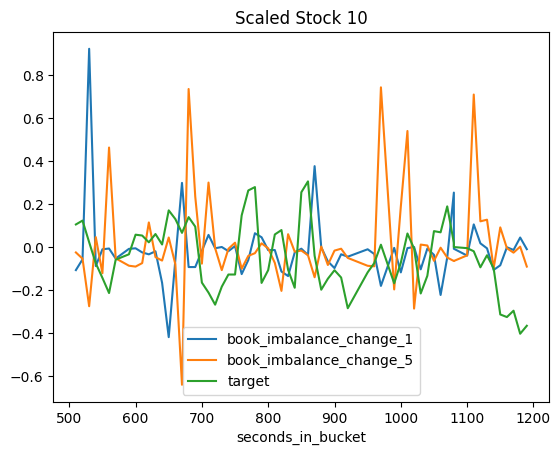

In [40]:
stock_id = 10
(
    scaled_df
    .query("stock_id=={} & seconds_in_bucket > 500 & seconds_in_bucket < 1200".format(stock_id))
    [['seconds_in_bucket',"book_imbalance_change_1", 'book_imbalance_change_5', "target"]]
    .replace(0, np.nan)
    .set_index('seconds_in_bucket')
    .plot(title='Scaled Stock {}'.format(stock_id))
)

In [111]:
"""
For now, it seems like stock_id and time doesn't really affect the Target, 
so it will not be put into training for now. 
"""
train_df = df.sort_values(by=["seconds_in_bucket", "stock_id"])
print(train_df)
train_df = train_df.drop(["stock_id", "seconds_in_bucket", "book_imbalance"], axis=1)

         stock_id  seconds_in_bucket     target  book_imbalance  \
1146            0                 60  -0.200272        0.162739   
1147            1                 60  -4.680157       -0.866703   
1148            2                 60   9.080172       -0.005238   
1150            4                 60 -13.779998       -0.990952   
1151            5                 60  -3.370047       -0.970604   
...           ...                ...        ...             ...   
5237975       195             259740   2.310276       -0.816784   
5237976       196             259740  -8.220077        0.374254   
5237977       197             259740   1.169443       -0.829388   
5237978       198             259740  -1.540184       -0.684154   
5237979       199             259740  -6.530285       -0.091024   

         book_imbalance_change_1  book_imbalance_change_2  \
1146                   -0.736955                -1.561766   
1147                   -2.223758                -2.216891   
1148        

In [112]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4072717 entries, 1146 to 5237979
Data columns (total 7 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   target                   float64
 1   book_imbalance_change_1  float64
 2   book_imbalance_change_2  float64
 3   book_imbalance_change_3  float64
 4   book_imbalance_change_4  float64
 5   book_imbalance_change_5  float64
 6   book_imbalance_change_6  float64
dtypes: float64(7)
memory usage: 248.6 MB


## Train Data Preperation

In [113]:
scaled_df_np = train_df.to_numpy()

In [114]:
X = scaled_df_np[:, 1:]
y = scaled_df_np[:, 0]

X.shape, y.shape

((4072717, 6), (4072717,))

In [115]:
# reverse the order of columns for better approximation result
X = dc(np.flip(X, axis=1))
X

array([[ -0.78426358,  -1.64112809,  -1.36612636,   0.69807072,
         -1.56176627,  -0.736955  ],
       [  0.18930027,   0.08319294,   0.08319294, -10.99053565,
         -2.21689105,  -2.22375806],
       [ -1.01573407,  -1.00534435,  -1.00556268,  -1.00534433,
         -0.98822138,  -1.00545262],
       ...,
       [  0.31488473,   0.09344857,   0.35105143,  -0.15116387,
          0.52548429,  -8.65234096],
       [  8.150097  ,   3.67600783,   9.46946459,   7.71529987,
          3.30608182,   0.33238401],
       [ -0.08506967,   1.49203458,  -0.83553951,  -1.28274921,
         -2.24400118,  -1.64069747]])

In [116]:
split_index = int(len(X) * 0.90)

split_index

3665445

In [117]:
# split train and test
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3665445, 6), (407272, 6), (3665445,), (407272,))

In [118]:
# reshape the array for PyTorch training
X_train = X_train.reshape((-1, LOOKBACK, 1))
X_test = X_test.reshape((-1, LOOKBACK, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3665445, 6, 1), (407272, 6, 1), (3665445, 1), (407272, 1))

In [119]:
# transform into torch tensor
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3665445, 6, 1]),
 torch.Size([407272, 6, 1]),
 torch.Size([3665445, 1]),
 torch.Size([407272, 1]))

In [120]:
#generate dataset
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [121]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [122]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [123]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 6, 1]) torch.Size([16, 1])


## Model Construction

In [124]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 8, 8)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 8, num_layers=8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

In [125]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
epoch = 0

In [126]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = LOSS_FUNCTION(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [127]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = LOSS_FUNCTION(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

### Model Training

In [ ]:
for epoch in range(NUM_EPOCHS):
    train_one_epoch()
    validate_one_epoch()

In [54]:
# save the trained weights
weight_path = "weight/no_scale_val_loss_44.05"
torch.save(model.state_dict(), weight_path)

In [130]:
# load weights if necessary
model.load_state_dict(torch.load(weight_path))
model.eval()

LSTM(
  (lstm): LSTM(1, 8, num_layers=8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

### Model Evaluation
- really bad :(

In [131]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

train_predictions = predicted.flatten()
print(train_predictions)

[-0.04193277 -0.04193277 -0.04193277 ... -0.04193277 -0.04193277
 -0.04193277]


In [91]:
y_eval = y_train.flatten()
y_eval = y_eval.tolist()
y_eval

[-7.219910621643066,
 -10.669827461242676,
 -8.41975212097168,
 9.529590606689453,
 -2.0200014114379883,
 -3.3402442932128906,
 3.540515899658203,
 2.620220184326172,
 3.3998489379882812,
 -5.3501129150390625,
 9.08970832824707,
 -1.9598007202148438,
 -10.750293731689453,
 -1.4001131057739258,
 -1.4400482177734375,
 -2.650022506713867,
 -6.020069122314453,
 0.5400180816650391,
 17.14944839477539,
 -8.040070533752441,
 -1.2797117233276367,
 -2.9802322387695312,
 10.190010070800781,
 4.960298538208008,
 0.6699562072753906,
 0.1895427703857422,
 -1.990199089050293,
 11.310577392578125,
 3.540515899658203,
 1.5902519226074219,
 7.150173187255859,
 -3.039836883544922,
 -0.4297494888305664,
 -6.88016414642334,
 -2.499818801879883,
 -4.119873046875,
 7.8296661376953125,
 6.77943229675293,
 2.219676971435547,
 -2.8401613235473633,
 -4.699826240539551,
 4.190206527709961,
 -5.32984733581543,
 -1.379847526550293,
 2.199411392211914,
 -1.2099742889404297,
 -5.2100419998168945,
 -5.970001220703125

In [94]:
temp_df = df.sort_values(by="stock_id")
temp_df

,stock_id,seconds_in_bucket,target,book_imbalance,book_imbalance_change_1,book_imbalance_change_2,book_imbalance_change_3,book_imbalance_change_4,book_imbalance_change_5,book_imbalance_change_6
1146,0,60,-0.200272,0.162739,-0.736955,-1.561766,0.698071,-1.366126,-1.641128,-0.784264
3543380,0,176560,-3.420114,-0.430240,-0.305031,-0.434458,-0.507334,0.804016,-0.380647,-0.337900
3543180,0,176550,-2.819896,-0.619079,-0.186234,-0.291096,1.595823,-0.108805,-0.047296,1.561795
3542580,0,176520,4.719496,-0.238490,-0.656681,-0.632986,-0.013109,-11.652284,0.038211,-0.556265
3541980,0,176490,10.429621,-0.241658,-11.793777,0.052001,-0.550371,-0.555466,-0.696537,-0.743952
...,...,...,...,...,...,...,...,...,...,...
2402004,199,120320,7.430315,-0.227742,-0.538582,-0.164894,-1.737349,-2.864736,-0.439562,-0.311955
2401805,199,120310,12.060404,-0.493569,0.809867,-2.598007,-5.041315,0.214599,0.491152,5.240641
2401606,199,120300,13.920069,-0.272710,-1.882942,-3.232934,-0.328902,-0.176099,2.448120,-2.115352
2402800,199,120360,-2.409816,0.722913,-0.262815,0.017616,0.197508,-4.174269,-2.464665,-3.650850


In [90]:
temp_df[:split_index]

,stock_id,seconds_in_bucket,target,book_imbalance,book_imbalance_change_1,book_imbalance_change_2,book_imbalance_change_3,book_imbalance_change_4,book_imbalance_change_5,book_imbalance_change_6
1,1,0,-5.519986,-0.728751,0.652813,-6.998116,-8.032576,-6.500086,0.579248,2.126191
2,2,0,-8.389950,0.332935,-1.356231,-1.381157,-1.363815,-1.352185,-0.284384,-0.458778
3,3,0,-4.010200,-0.990340,0.105170,0.008562,0.008775,0.986953,0.266296,0.083266
4,4,0,-7.349849,0.948687,-2.008274,-3.113162,-3.077294,-2.775249,0.549515,-4.738816
5,5,0,6.779432,-0.484199,-0.310369,0.697924,0.383806,-5.169290,-1.537757,-1.793704
...,...,...,...,...,...,...,...,...,...,...
4734753,173,235030,1.970530,-0.307967,0.230934,-0.678647,-2.282637,-1.378403,-1.472086,-2.415056
4734754,174,235030,-6.759763,-0.557705,-0.383987,0.196833,0.157700,-0.253189,0.121699,-0.083973
4734755,175,235030,-3.079772,-0.088693,-1.130095,-0.883572,-1.526650,-0.727997,-1.223218,-0.897352
4734756,176,235030,-1.890063,0.499821,2.841357,-0.498483,-0.192314,0.401332,-1.844130,2.203149


/Users/danielbai/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


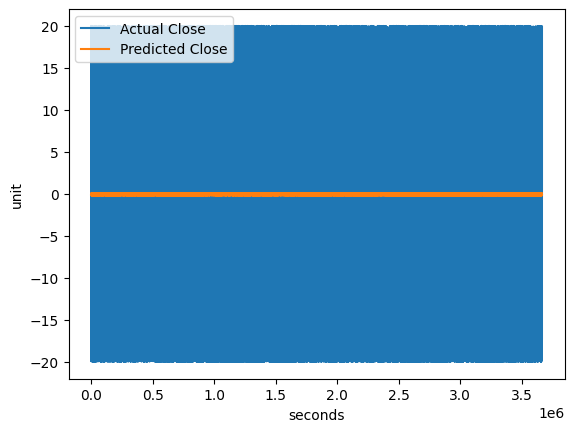

In [73]:
plt.plot(y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('seconds')
plt.ylabel('unit')
plt.legend()
plt.show()

In [277]:
test_df = pd.read_csv(TEST_FILE_PATH)